In [43]:
import tensorflow as tf
import timeit
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import cv2
import random
#!pip install pyod
tf.device('/device:GPU:0')
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.models import Model

In [2]:
tf.__version__

'2.9.2'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:


modelDense = DenseNet169()#weights='imagenet'

# remove last layers to extract features...

feature_layer = modelDense.layers[-2].output

last_layer = tf.keras.layers.Dense(1, activation='sigmoid')(feature_layer)

model = tf.keras.Model(inputs = modelDense.input, outputs = last_layer)
#model_featureEX.summary()

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

#model.summary()

58541896/58541896 [==============================] - 4s 0us/step


In [35]:
modelAlex = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelAlex.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [10]:
modelAlex.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

In [12]:
def load_images_preprocess_batch(folder, fnames, resize):
    images = []

    
    for filename in fnames:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = tf.image.per_image_standardization(img)
            img = tf.image.resize(img, (resize, resize))
            images.append(img)
            
    return images


In [13]:
def create_data_set(class_one, class_two):
  label1 = []
  label2 = []


  for i in range(len(class_one)):
    label1.append(1)
    img = class_one[i]
    #img = tf.image.per_image_standardization(img)
    #img = tf.image.resize(img, (227, 227))
    class_one[i] = img


  for i in range(len(class_two)):
    label2.append(0)
    img = class_two[i]
    #img = tf.image.per_image_standardization(img)
    #img = tf.image.resize(img, (227, 227))
    class_two[i] = img

  good_data = (class_one, label1)
  bad_data = (class_two, label2)

  comb_class = class_one + class_two
  comb_lab = label1 + label2

  z = list(zip(comb_class, comb_lab))

  random.shuffle(z)

  comb_class, comb_lab = zip(*z)

  combined_data = (comb_class, comb_lab)

  # need to shuffle

  return combined_data

In [14]:
def divide_data(data, train_perc, test_perc):
  cut_train = int(len(data[0])*train_perc)
  cut_test = int(len(data[0])*(1-test_perc))


  train = (data[0][:cut_train], data[1][:cut_train])
  test = (data[0][cut_train:cut_test], data[1][cut_train:cut_test])
  val = (data[0][cut_test:], data[1][cut_test:])

  return train, test, val

In [15]:
def divide_data_noval(data, train_perc):
  cut_train = int(len(data[0])*train_perc)


  train = (data[0][:cut_train], data[1][:cut_train])
  test = (data[0][cut_train:], data[1][cut_train:])

  return train, test

In [17]:
folderGood = "drive/My Drive/Masterthesis/data/skanner_frames3_crop"
folderBad = "drive/My Drive/Masterthesis/data/skanner_fake_errors/errors"
fnamesG = list(fname for fname in os.listdir(folderGood))
fnamesB = list(fname for fname in os.listdir(folderBad))

imgsGood = load_images_preprocess_batch(folderGood, fnamesG[0:100], 227)
imgsBad = load_images_preprocess_batch(folderBad, fnamesB, 227)

dataset = create_data_set(imgsBad, imgsGood)

#train_data_autoenc = fnames[0:int(len(fnames)*0.7)]
#test_data_autoenc = fnames[int(len(fnames)*0.7):]

#print(len(train_data_autoenc), len(test_data_autoenc))

In [9]:
train, test, val = divide_data(dataset, 0.8, 0.1)

In [18]:
train, test = divide_data_noval(dataset, 0.7)

In [19]:
len(test[1])

50

In [20]:
train_x = np.asarray(train[0])
train_y = np.asarray(train[1])
#validation_x = np.asarray(val[0])
#validation_y = np.asarray(val[1])
#validata = (validation_x, validation_y)
test_x = np.asarray(test[0])
test_y = np.asarray(test[1])

In [36]:
historyAlex = modelAlex.fit(train_x, train_y, epochs=30, batch_size=16)

Epoch 1/30
8/8 [==============================] - 23s 3s/step - loss: 3.1458 - accuracy: 0.5439
Epoch 2/30
8/8 [==============================] - 22s 3s/step - loss: 2.0279 - accuracy: 0.6842
Epoch 3/30
8/8 [==============================] - 20s 3s/step - loss: 1.9868 - accuracy: 0.6930
Epoch 4/30
8/8 [==============================] - 20s 2s/step - loss: 2.4110 - accuracy: 0.6404
Epoch 5/30
8/8 [==============================] - 23s 3s/step - loss: 2.3283 - accuracy: 0.6930
Epoch 6/30
8/8 [==============================] - 20s 2s/step - loss: 2.2033 - accuracy: 0.7456
Epoch 7/30
8/8 [==============================] - 20s 3s/step - loss: 1.9111 - accuracy: 0.7281
Epoch 8/30
8/8 [==============================] - 22s 3s/step - loss: 2.3377 - accuracy: 0.7368
Epoch 9/30
8/8 [==============================] - 23s 3s/step - loss: 1.5905 - accuracy: 0.8158
Epoch 10/30
8/8 [==============================] - 23s 3s/step - loss: 2.1444 - accuracy: 0.7982
Epoch 11/30
8/8 [======================

In [35]:
history = model.fit(train_x,
                    train_y,
                    epochs=10,
                    batch_size=16)

Epoch 1/10
8/8 [==============================] - 133s 14s/step - loss: 0.5120 - accuracy: 0.7456
Epoch 2/10
8/8 [==============================] - 113s 14s/step - loss: 0.3172 - accuracy: 0.8947
Epoch 3/10
8/8 [==============================] - 115s 14s/step - loss: 0.2540 - accuracy: 0.9123
Epoch 4/10
8/8 [==============================] - 113s 14s/step - loss: 0.1866 - accuracy: 0.9912
Epoch 5/10
8/8 [==============================] - 114s 14s/step - loss: 0.1946 - accuracy: 0.9474
Epoch 6/10
8/8 [==============================] - 115s 14s/step - loss: 0.1681 - accuracy: 0.9912
Epoch 7/10
8/8 [==============================] - 113s 14s/step - loss: 0.1196 - accuracy: 1.0000
Epoch 8/10
8/8 [==============================] - 114s 14s/step - loss: 0.1331 - accuracy: 0.9825
Epoch 9/10
8/8 [==============================] - 113s 14s/step - loss: 0.1310 - accuracy: 1.0000
Epoch 10/10
8/8 [==============================] - 113s 14s/step - loss: 0.1029 - accuracy: 0.9912


In [11]:
history = model.fit(train_x,
                    train_y,
                    epochs=10,
                    batch_size=16,
                    validation_data=validata,
                    validation_freq=1)

Epoch 1/10
9/9 [==============================] - 162s 15s/step - loss: 0.5673 - accuracy: 0.7099 - val_loss: 0.6264 - val_accuracy: 0.7059
Epoch 2/10
9/9 [==============================] - 135s 15s/step - loss: 0.3242 - accuracy: 0.9008 - val_loss: 0.6648 - val_accuracy: 0.7059
Epoch 3/10
9/9 [==============================] - 130s 14s/step - loss: 0.2254 - accuracy: 0.9695 - val_loss: 0.6541 - val_accuracy: 0.7059
Epoch 4/10
9/9 [==============================] - 131s 15s/step - loss: 0.1975 - accuracy: 0.9695 - val_loss: 0.6216 - val_accuracy: 0.7059
Epoch 5/10
9/9 [==============================] - 130s 14s/step - loss: 0.1795 - accuracy: 0.9542 - val_loss: 0.6106 - val_accuracy: 0.6471
Epoch 6/10
9/9 [==============================] - 136s 15s/step - loss: 0.1361 - accuracy: 0.9847 - val_loss: 0.5728 - val_accuracy: 0.7647
Epoch 7/10
9/9 [==============================] - 131s 14s/step - loss: 0.1083 - accuracy: 0.9924 - val_loss: 0.5316 - val_accuracy: 0.8235
Epoch 8/10
9/9 [====

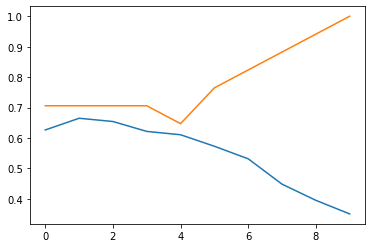

In [12]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])

In [ ]:
model.evaluate(test_x, test_y)

In [38]:
modelAlex.evaluate(test_x, test_y)

2/2 [==============================] - 2s 749ms/step - loss: 0.2437 - accuracy: 0.9200


[0.24372883141040802, 0.9200000166893005]

In [39]:
def generate_confusion_data(testx, testy):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for i in range(len(testx)):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(testy[i])
    # compute predictions
    img_tensor = np.expand_dims(testx[i], axis=0)
    preds = modelAlex.predict(img_tensor)
    # append predicted labels
    y_pred.append((1 if preds > 0.5 else 0))
    #y_pred.append(preds)

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return (correct_labels, predicted_labels)

1/1 [==============================] - 0s 84ms/step


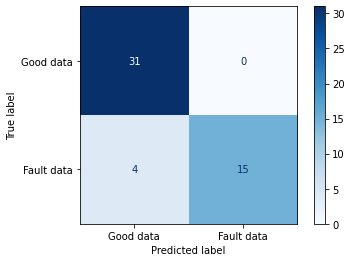

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

labels = ["Good data", "Fault data"]

y_test, y_pred = generate_confusion_data(test_x, test_y)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

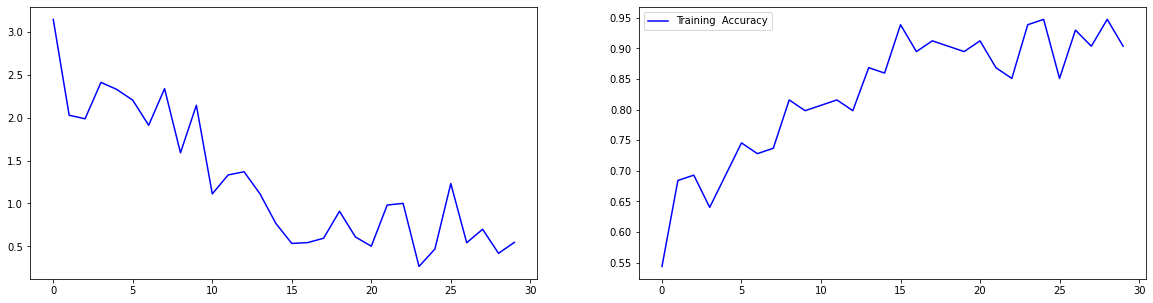

In [41]:
historyAlex.history.keys()
f,ax=plt.subplots(1,2,figsize=(20,5)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(historyAlex.history['loss'],color='b',label='Training Loss')
#ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(historyAlex.history['accuracy'],color='b',label='Training  Accuracy')
#ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

0.5
Balanced accuracy:  0.5
F1 score:  0.5507246376811594
MCC:  0.0


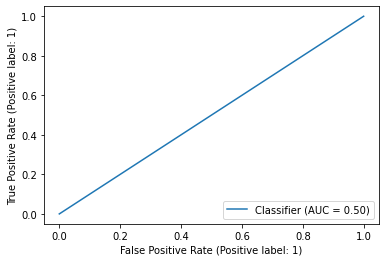

In [28]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

roc = RocCurveDisplay.from_predictions(y_test, y_pred)
#print(fpr)
print(roc)
auc = roc_auc_score(y_test, y_pred)
print(auc)

print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

print("F1 score: " , f1_score(y_test, y_pred))

print("MCC: " , matthews_corrcoef(y_test, y_pred))


#ax = plt.plot(tpr, fpr)

In [ ]:
model.save("drive/My Drive/Masterthesis/")

## HYPERMETER TUNING DENSENET

In [48]:
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([30, 50, 70, 100]))
#HP_LEARNINGRATE = hp.HParam('learningrate', hp.Discrete([0.001, 0.01, 0.1]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_TRANSFER = hp.HParam('Transferlearning', hp.Discrete(['imagenet', 'None']))

METRIC_LOSS = 'loss'
METRIC_ACCURACY = 'acc'
METRIC_TEST_ACCURACY = 'test_acc'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_EPOCHS, HP_OPTIMIZER, HP_TRANSFER],
    metrics=[hp.Metric(METRIC_LOSS, display_name='Loss'), hp.Metric(METRIC_ACCURACY, display_name='Accuracy'), hp.Metric(METRIC_TEST_ACCURACY, display_name='Test Accuracy')],
  )

In [49]:
def denseModel(hparams):

  if hparams[HP_TRANSFER] == 'None':
    hptransfer = None
  else:
    hptransfer = hparams[HP_TRANSFER]


  modelDense = DenseNet169(weights=hptransfer)#weights='imagenet'

  # remove last layers to extract features...

  feature_layer = modelDense.layers[-2].output

  last_layer = tf.keras.layers.Dense(1, activation='sigmoid')(feature_layer)

  model = tf.keras.Model(inputs = modelDense.input, outputs = last_layer)
  #model_featureEX.summary()

  model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER], metrics=['accuracy'])

  model.summary()

  _, acc = model.fit(train_x, train_y, epochs=hparams[HP_EPOCHS], batch_size=16)

  loss, test_acc = model.evaluate(test_x, test_y)

  return loss, acc, test_acc


In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    loss, acc, test_acc = denseModel(hparams)
    tf.summary.scalar(METRIC_LOSS, loss, step=1)
    tf.summary.scalar(METRIC_ACCURACY, acc, step=1)
    tf.summary.scalar(METRIC_TEST_ACCURACY, test_acc, step=1)

In [46]:
session_num = 0

for epochs in HP_EPOCHS.domain.values:
  for optimizer in (HP_OPTIMIZER.domain.values):
    for transferOnOff in HP_TRANSFER.domain.values:
      hparams = {
          HP_EPOCHS: epochs,
          HP_OPTIMIZER: optimizer,
          HP_TRANSFER: transferOnOff,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Run before run
#!rm -rf ./logs/
%tensorboard --logdir logs